# Introduction #

In this exercise, you'll apply target encoding to features in the [*Ames*](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) dataset.

Run this cell to set everything up!

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from category_encoders import MEstimateEncoder
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


df = pd.read_csv("Data/ames.csv")


First you'll need to choose which features you want to apply a target encoding to. Categorical features with a large number of categories are often good candidates. Run this cell to see how many categories each categorical feature in the *Ames* dataset has.

In [14]:
df.select_dtypes(["object"]).nunique().sort_values(ascending=False)

Neighborhood     28
Exterior2nd      17
MSSubClass       16
Exterior1st      16
OverallQual      10
SaleType         10
Condition1        9
OverallCond       9
RoofMatl          8
Functional        8
Condition2        8
HouseStyle        8
BsmtFinType1      7
BsmtFinType2      7
MSZoning          7
GarageType        7
BsmtQual          6
Heating           6
FireplaceQu       6
GarageQual        6
GarageCond        6
MiscFeature       6
BsmtCond          6
Electrical        6
Foundation        6
SaleCondition     6
RoofStyle         6
BldgType          5
Fence             5
PoolQC            5
BsmtExposure      5
KitchenQual       5
ExterCond         5
HeatingQC         5
MasVnrType        5
LotConfig         5
GarageFinish      4
LandContour       4
LotShape          4
ExterQual         4
LandSlope         3
Utilities         3
PavedDrive        3
Alley             3
CentralAir        2
Street            2
dtype: int64

We talked about how the M-estimate encoding uses smoothing to improve estimates for rare categories. To see how many times a category occurs in the dataset, you can use the `value_counts` method. This cell shows the counts for `SaleType`, but you might want to consider others as well.

In [15]:
df["Neighborhood"].value_counts()

North_Ames                                 443
College_Creek                              267
Old_Town                                   239
Edwards                                    194
Somerset                                   182
Northridge_Heights                         166
Gilbert                                    165
Sawyer                                     151
Northwest_Ames                             131
Sawyer_West                                125
Mitchell                                   114
Brookside                                  108
Crawford                                   103
Iowa_DOT_and_Rail_Road                      93
Timberland                                  72
Northridge                                  71
Stone_Brook                                 51
South_and_West_of_Iowa_State_University     48
Clear_Creek                                 44
Meadow_Village                              37
Briardale                                   30
Bloomington_H

# 1) Choose Features for Encoding

Which features did you identify for target encoding? After you've thought about your answer, run the next cell for some discussion.

The Neighborhood feature looks promising. It has the most categories of any feature, and several categories are rare. Others that could be worth considering are SaleType, MSSubClass, Exterior1st, Exterior2nd. In fact, almost any of the nominal features would be worth trying because of the prevalence of rare categories.

-------------------------------------------------------------------------------

Now you'll apply a target encoding to your choice of feature. As we discussed in the tutorial, to avoid overfitting, we need to fit the encoder on data heldout from the training set. Run this cell to create the encoding and training splits:

In [16]:
# Encoding split
X_encode = df.sample(frac=0.20, random_state=0)
y_encode = X_encode.pop("SalePrice")

# Training split
X_pretrain = df.drop(X_encode.index)
y_train = X_pretrain.pop("SalePrice")

# 2) Apply M-Estimate Encoding

Apply a target encoding to your choice of categorical features. Also choose a value for the smoothing parameter `m` (any value is okay for a correct answer).

In [18]:
# YOUR CODE HERE: Create the MEstimateEncoder
# Choose a set of features to encode and a value for m
encoder = MEstimateEncoder(cols=["Neighborhood"], m=5.0)


# Fit the encoder on the encoding split
encoder.fit(X_encode, y_encode)

# Encode the training split
X_train = encoder.transform(X_pretrain, y_train)


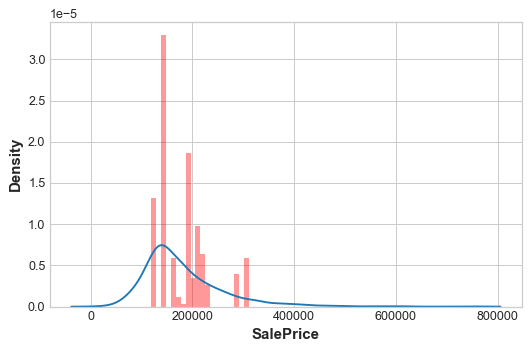

In [19]:
feature = encoder.cols

plt.figure(dpi=90)
ax = sns.distplot(y_train, kde=True, hist=False)
ax = sns.distplot(X_train[feature], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
ax.set_xlabel("SalePrice");

From the distribution plots, does it seem like the encoding is informative?

And this cell will show you the score of the encoded set compared to the original set:

In [20]:
X = df.copy()
y = X.pop("SalePrice")
score_base = score_dataset(X, y)
score_new = score_dataset(X_train, y_train)

print(f"Baseline Score: {score_base:.4f} RMSLE")
print(f"Score with Encoding: {score_new:.4f} RMSLE")

Baseline Score: 0.1428 RMSLE
Score with Encoding: 0.1383 RMSLE


Do you think that target encoding was worthwhile in this case? Depending on which feature or features you chose, you may have ended up with a score significantly worse than the baseline. In that case, it's likely the extra information gained by the encoding couldn't make up for the loss of data used for the encoding.


In this question, you'll explore the problem of overfitting with target encodings. This will illustrate this importance of training fitting target encoders on data held-out from the training set.

So let's see what happens when we fit the encoder and the model on the *same* dataset. To emphasize how dramatic the overfitting can be, we'll mean-encode a feature that should have no relationship with `SalePrice`, a count: `0, 1, 2, 3, 4, 5, ...`.